# Data Scientist Professional Practical Exam Submission


## Data Validation
This dataset contains 947 observations (rows) with 8 different features (columns). After validation of all features, I had to make changes to 6 features while the rest remained as described in the data dictionary:

- recipe: 947 unique recipe identifiers without missing values, matching the description in the data dictionary, hence no cleaning required.
- calories: numerical feature describing number of calories in the recipe. It contained 52 missing values which I replaced with median of all values.
- carbohydrate: numerical feature describing amount of carbohydrate in grams. It contained 52 missing values which I replaced with median of all values.
- sugar: numerical feature describing amount of sugar in grams. It contained 52 missing values which I replaced with median of all values.
- protein: numerical feature describing amount of protein in grams. It contained 52 missing values which I replaced with median of all values.
- category: 11 unique categories of recipe without missing values, matching the description in the data dictionary, hence no cleaning required.
- servings: according to data dictionary it is numerical feature describing number of servings a recipe can offer, however I found it is categorical with integers, and  mixture of integer and strings values and there was no missing values. Therefore, I removed the strings and convert the feature to integer data type of 4 unique values.
- high_traffic: 1 unique value describing whether the traffic was high when the recipe was shown on the webpage. It contained 373 missing values which I created the new category called "No" for them, meaning that the recipe did not drive high traffic, moreover, I renamed the existed category to "Yes" to make this feature more descriptive. I did so because this seem to be target variable for the underlined problem chich requires atleat two unique categories to solve it. 

In [77]:
# Import the required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use("ggplot")

In [78]:
# Read the dataset.
rec = pd.read_csv("recipe_site_traffic_2212.csv")
rec.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [79]:
# Check data informations.
rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [80]:
# Check the descriptive statistics of numeric features
rec.describe().T

,count,mean,std,min,25%,50%,75%,max
recipe,947.0,474.000000,273.519652,1.00,237.500,474.00,710.500,947.00
calories,895.0,435.939196,453.020997,0.14,110.430,288.55,597.650,3633.16
carbohydrate,895.0,35.069676,43.949032,0.03,8.375,21.48,44.965,530.42
sugar,895.0,9.046547,14.679176,0.01,1.690,4.55,9.800,148.75
protein,895.0,24.149296,36.369739,0.00,3.195,10.80,30.200,363.36


In [81]:
# Check null values in each column.
rec.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

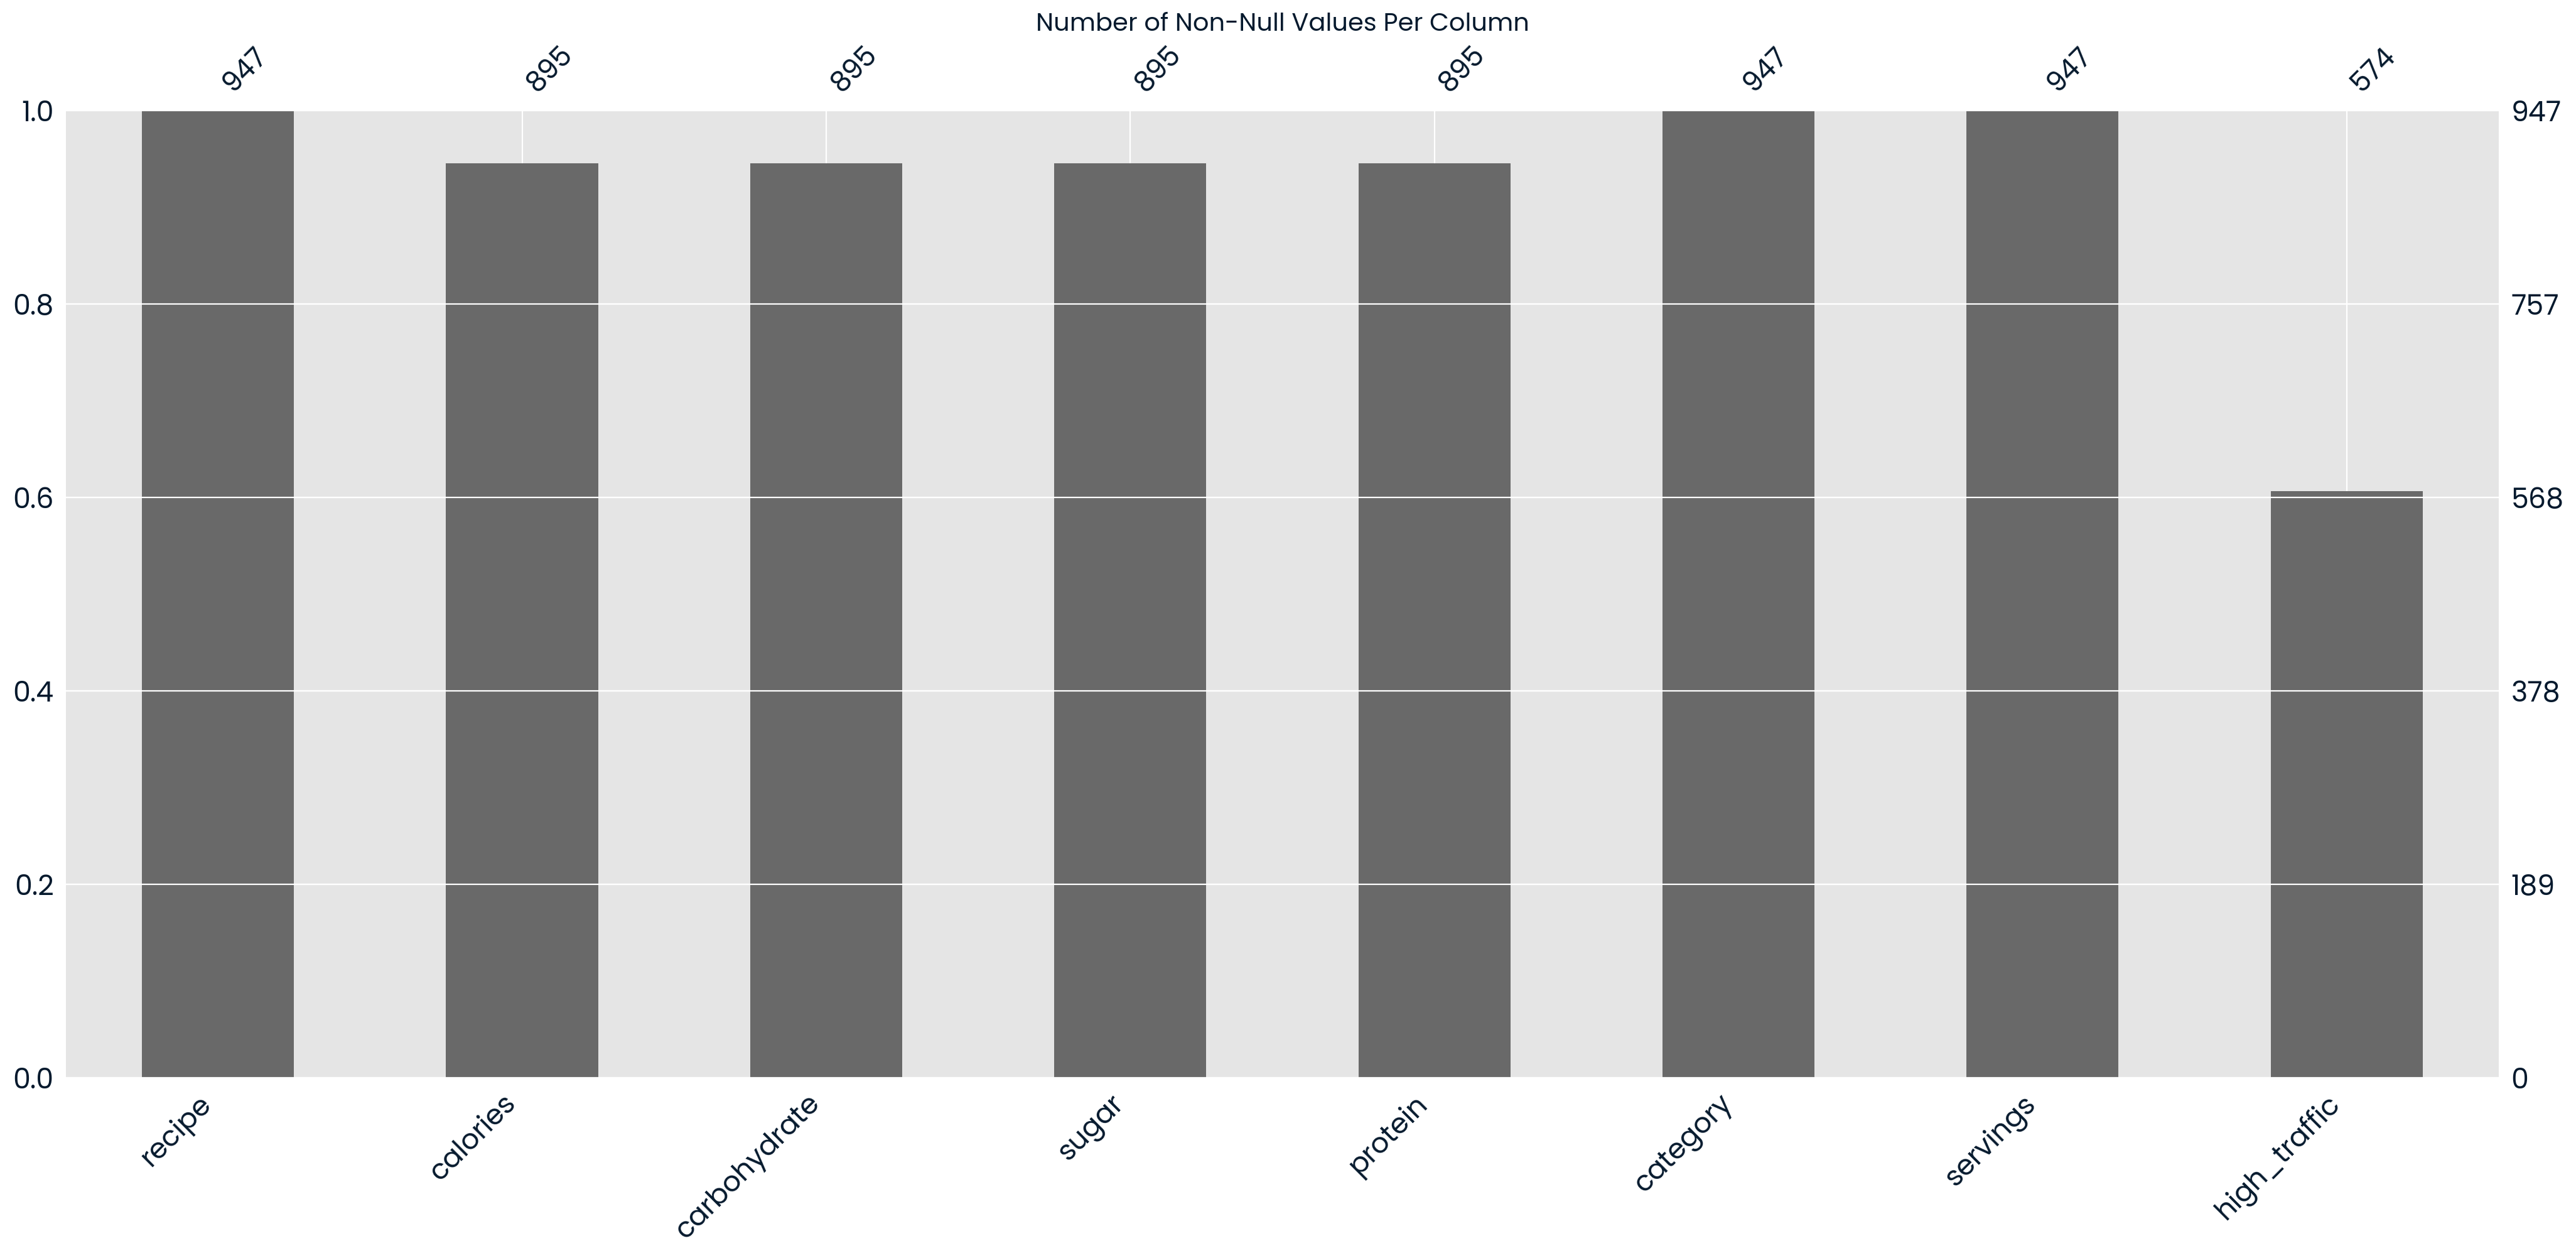

In [82]:
# Visualize the missing values
msno.bar(rec)
plt.title("Number of Non-Null Values Per Column")
plt.show()

In [83]:
# Check the servings column.
rec["servings"].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [84]:
# Clean and change the datatype for the serving column to integer.
rec["servings"] = rec["servings"].str.replace(" as a snack", "").astype(int)
rec["servings"].value_counts()

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

In [85]:
# Check the values of category column.
rec["category"].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

In [86]:
# Check values for the recipe column.
rec["recipe"].nunique()

947

## Exploratory Data Analysis:

- ## Numeric Features
I have investigated the distribution of each numerical feature and found that both of them exihibit the right skewed distributions with some outliers. This is the reason I replaced their missing values with the median, it is less sensitive to outliers compared to mean. Moreover, there was any duplicate row in the dataset.

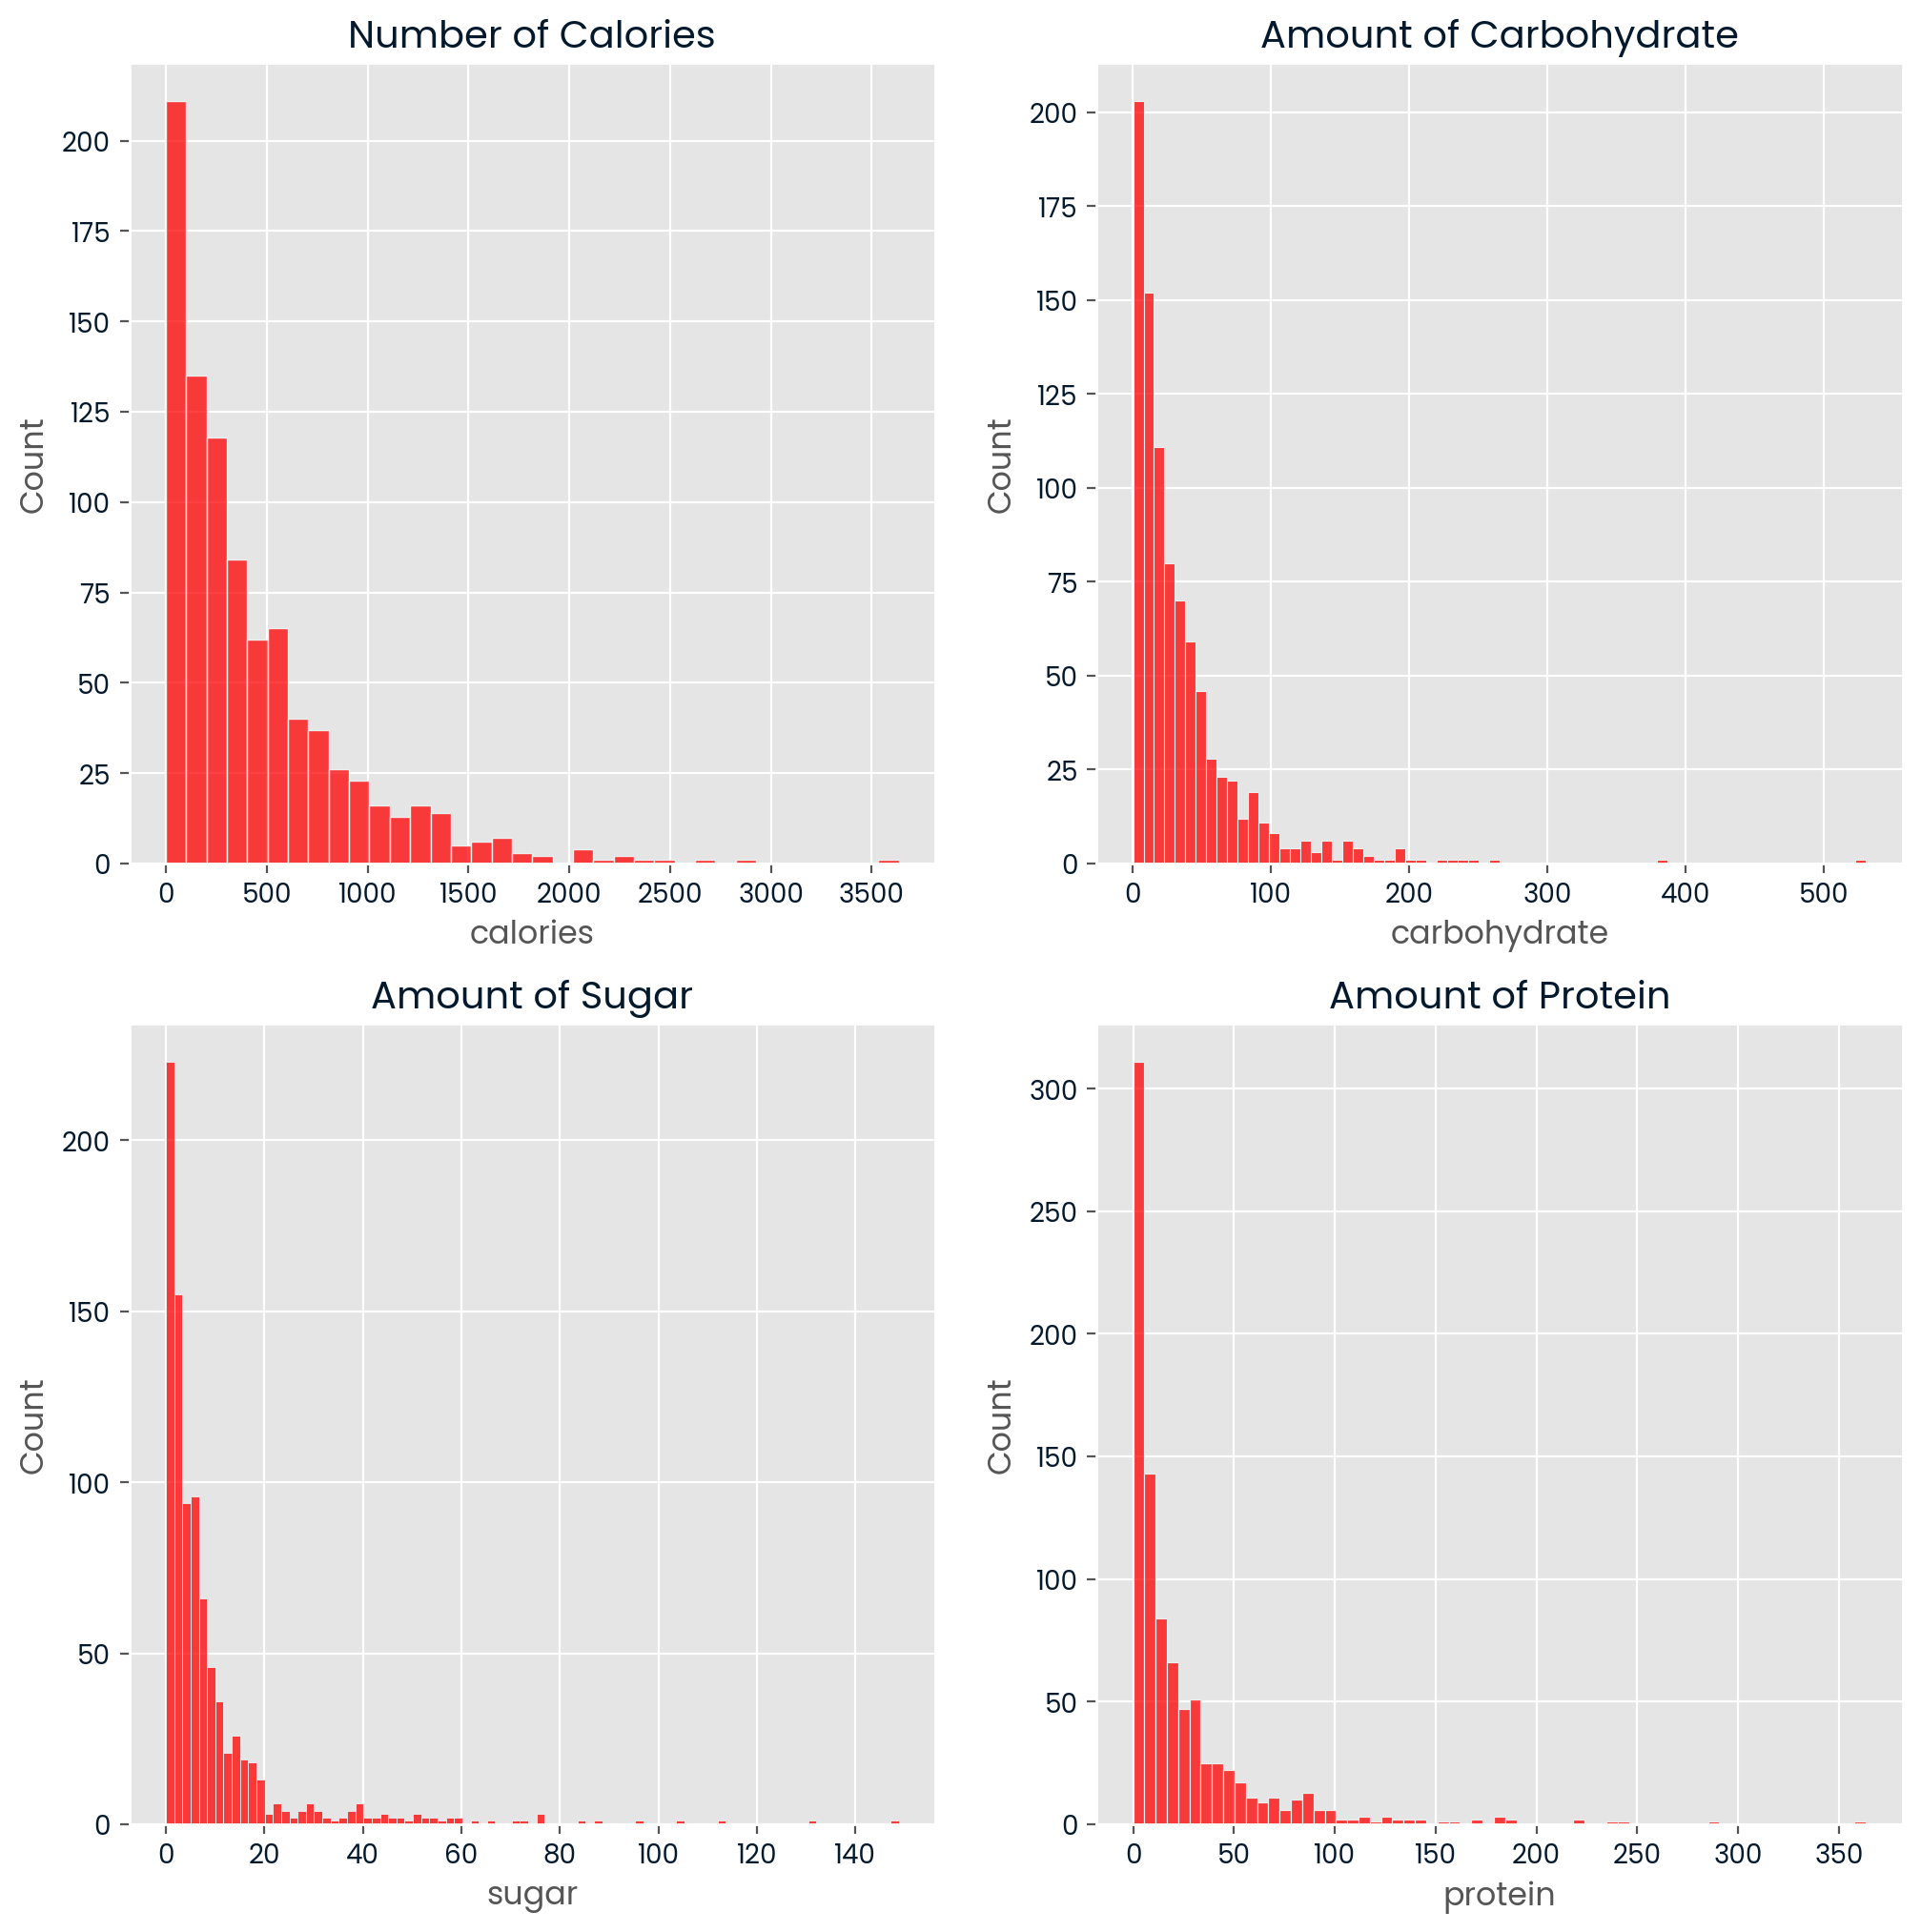

In [87]:
# Check the distributions of numeric columns
fig, ax = plt.subplots(2, 2, figsize = (12, 12))
sns.histplot(rec["calories"], color = "red", ax = ax[0,0]).set(title = "Number of Calories")
sns.histplot(rec["carbohydrate"], color = "red", ax = ax[0,1]).set(title = "Amount of Carbohydrate")
sns.histplot(rec["sugar"], color = "red", ax = ax[1,0]).set(title = "Amount of Sugar")
sns.histplot(rec["protein"], color = "red", ax = ax[1,1]).set(title = "Amount of Protein")
plt.show()

In [88]:
# Fill null values to numerical features using median.
numeric = ["calories", "carbohydrate", "sugar", "protein"]
# Loop through each column to fill null values with median
for i in numeric:
    rec[i].fillna(rec[i].median(), inplace=True)
# Fill null values in the categorical feature with new value
rec["high_traffic"].fillna("No", inplace = True)
rec["high_traffic"].replace({"High": "Yes"}, inplace = True)
# Print to check if null values have been replaced.
rec.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

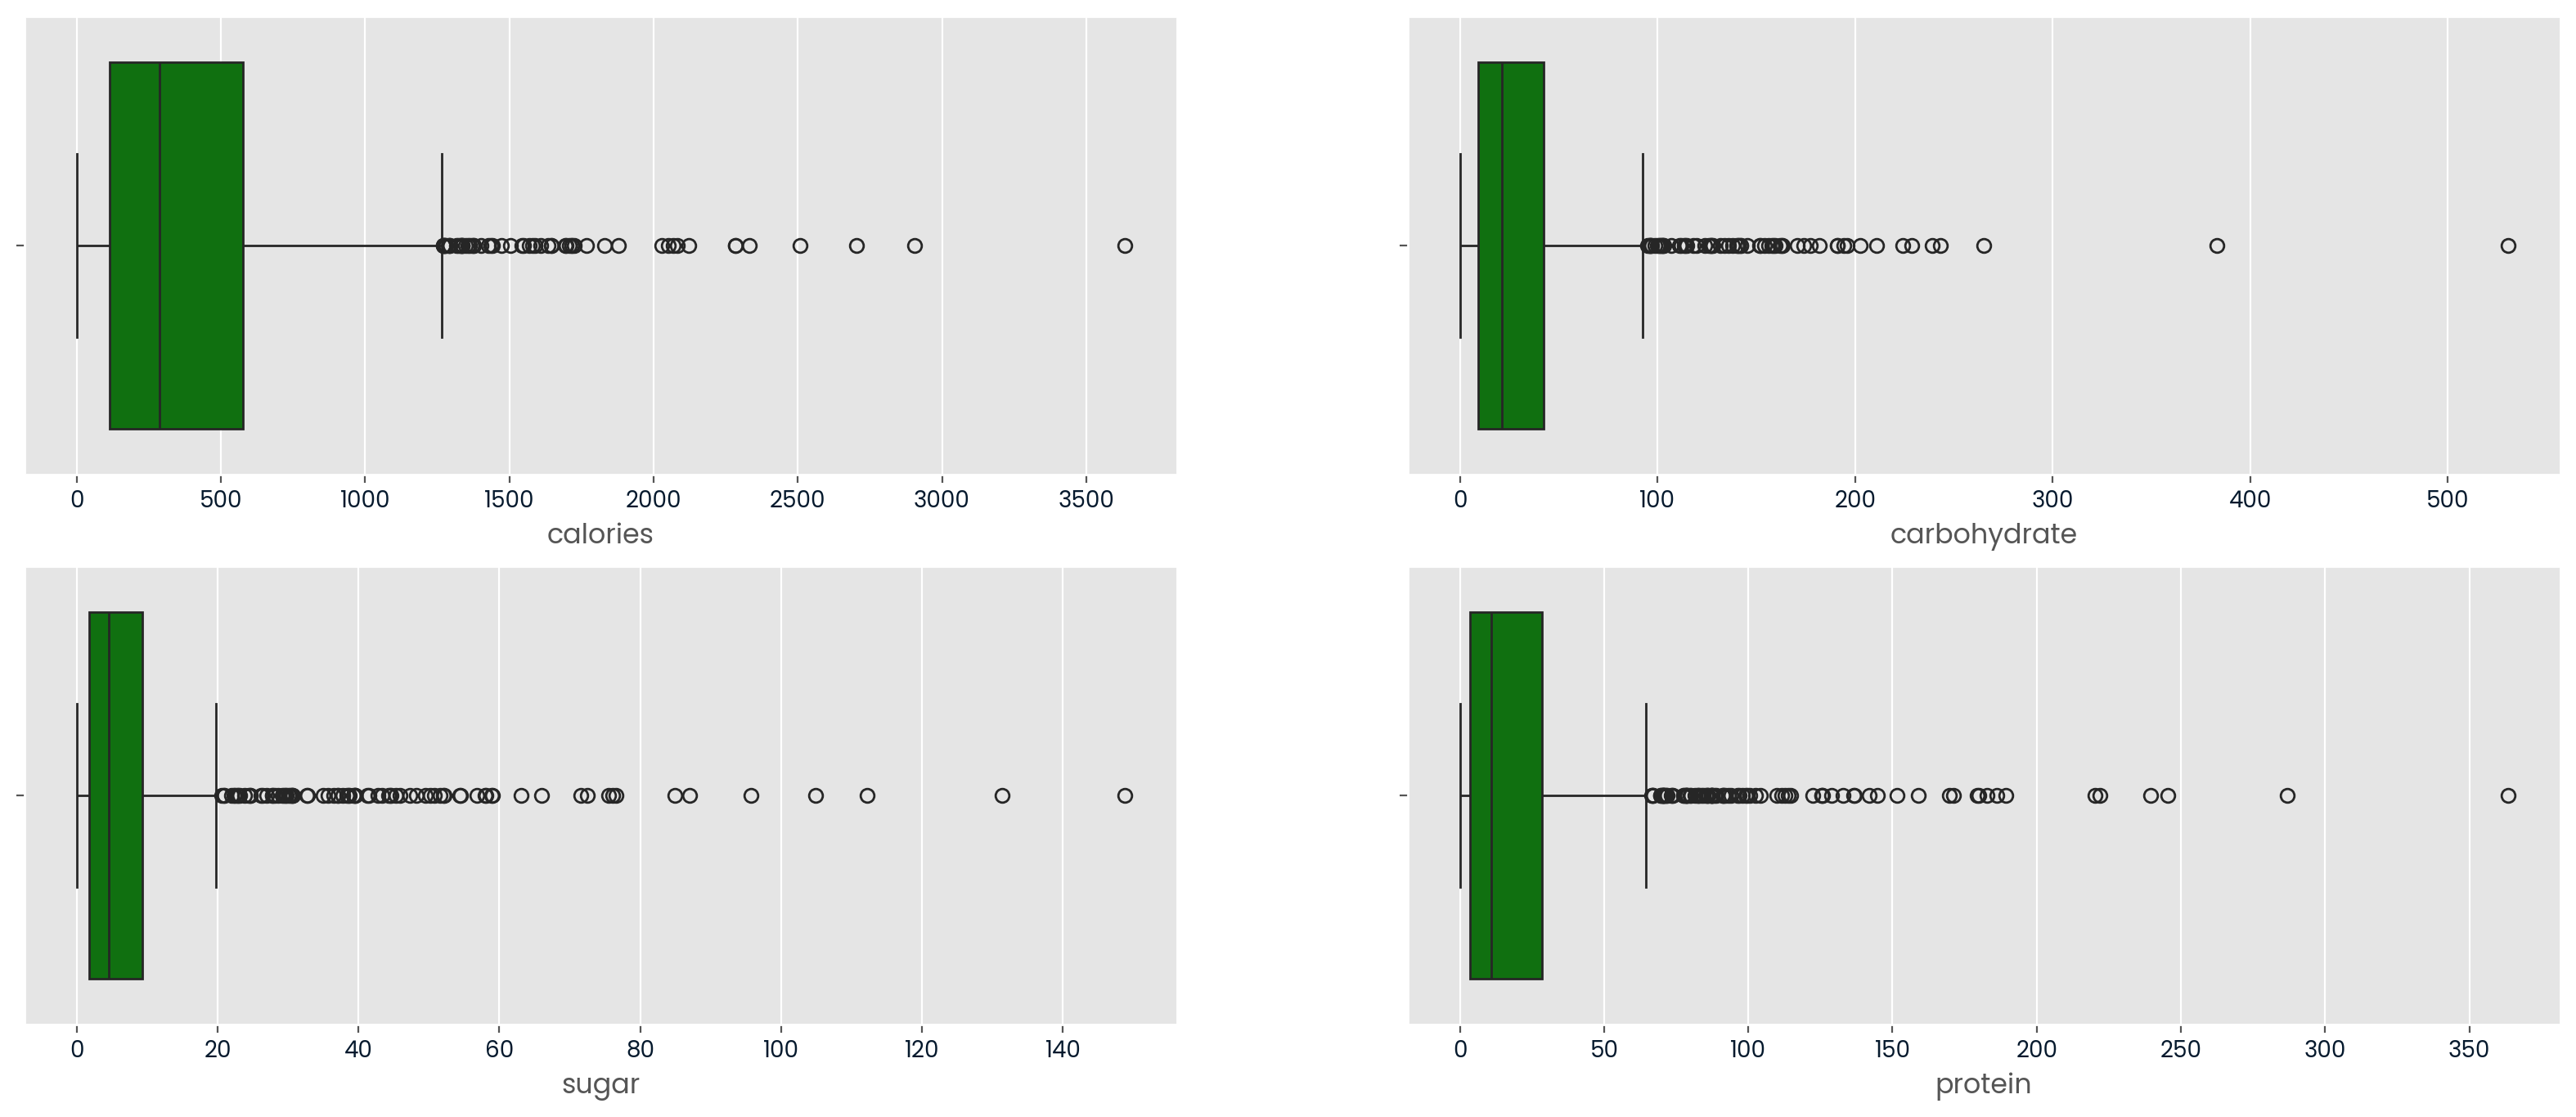

In [89]:
# Check for the potential outliers in the numerical features
fig, ax = plt.subplots(2, 2, figsize = (20, 8))
sns.boxplot(data = rec, x = "calories", ax = ax[0,0], color = "green")
sns.boxplot(data = rec, x = "carbohydrate", ax = ax[0,1], color = "green")
sns.boxplot(data = rec, x = "sugar", ax = ax[1,0], color = "green")
sns.boxplot(data = rec, x = "protein",  ax = ax[1,1], color = "green")
plt.show()

In [90]:
# Check for duplicates.
rec.duplicated().sum()

0

- ## Categorical Features
I also investigated the categorical features and found that, Breakfast was the most common category of recipe while One Dish Meal was the least common in the category column, the most common number of servings for the recipes was 4 while the least one was 1 in the servings column.
- ## Target variable (high_traffic)
Because we are going to predict whether the recipe will drive high traffic on the webpage when shown, high traffic is our target variable. After data cleaning and manipulation, it has two values, with "Yes" as the most common class indicating that most recipes we have in the dataset had led to high traffic on webpage.

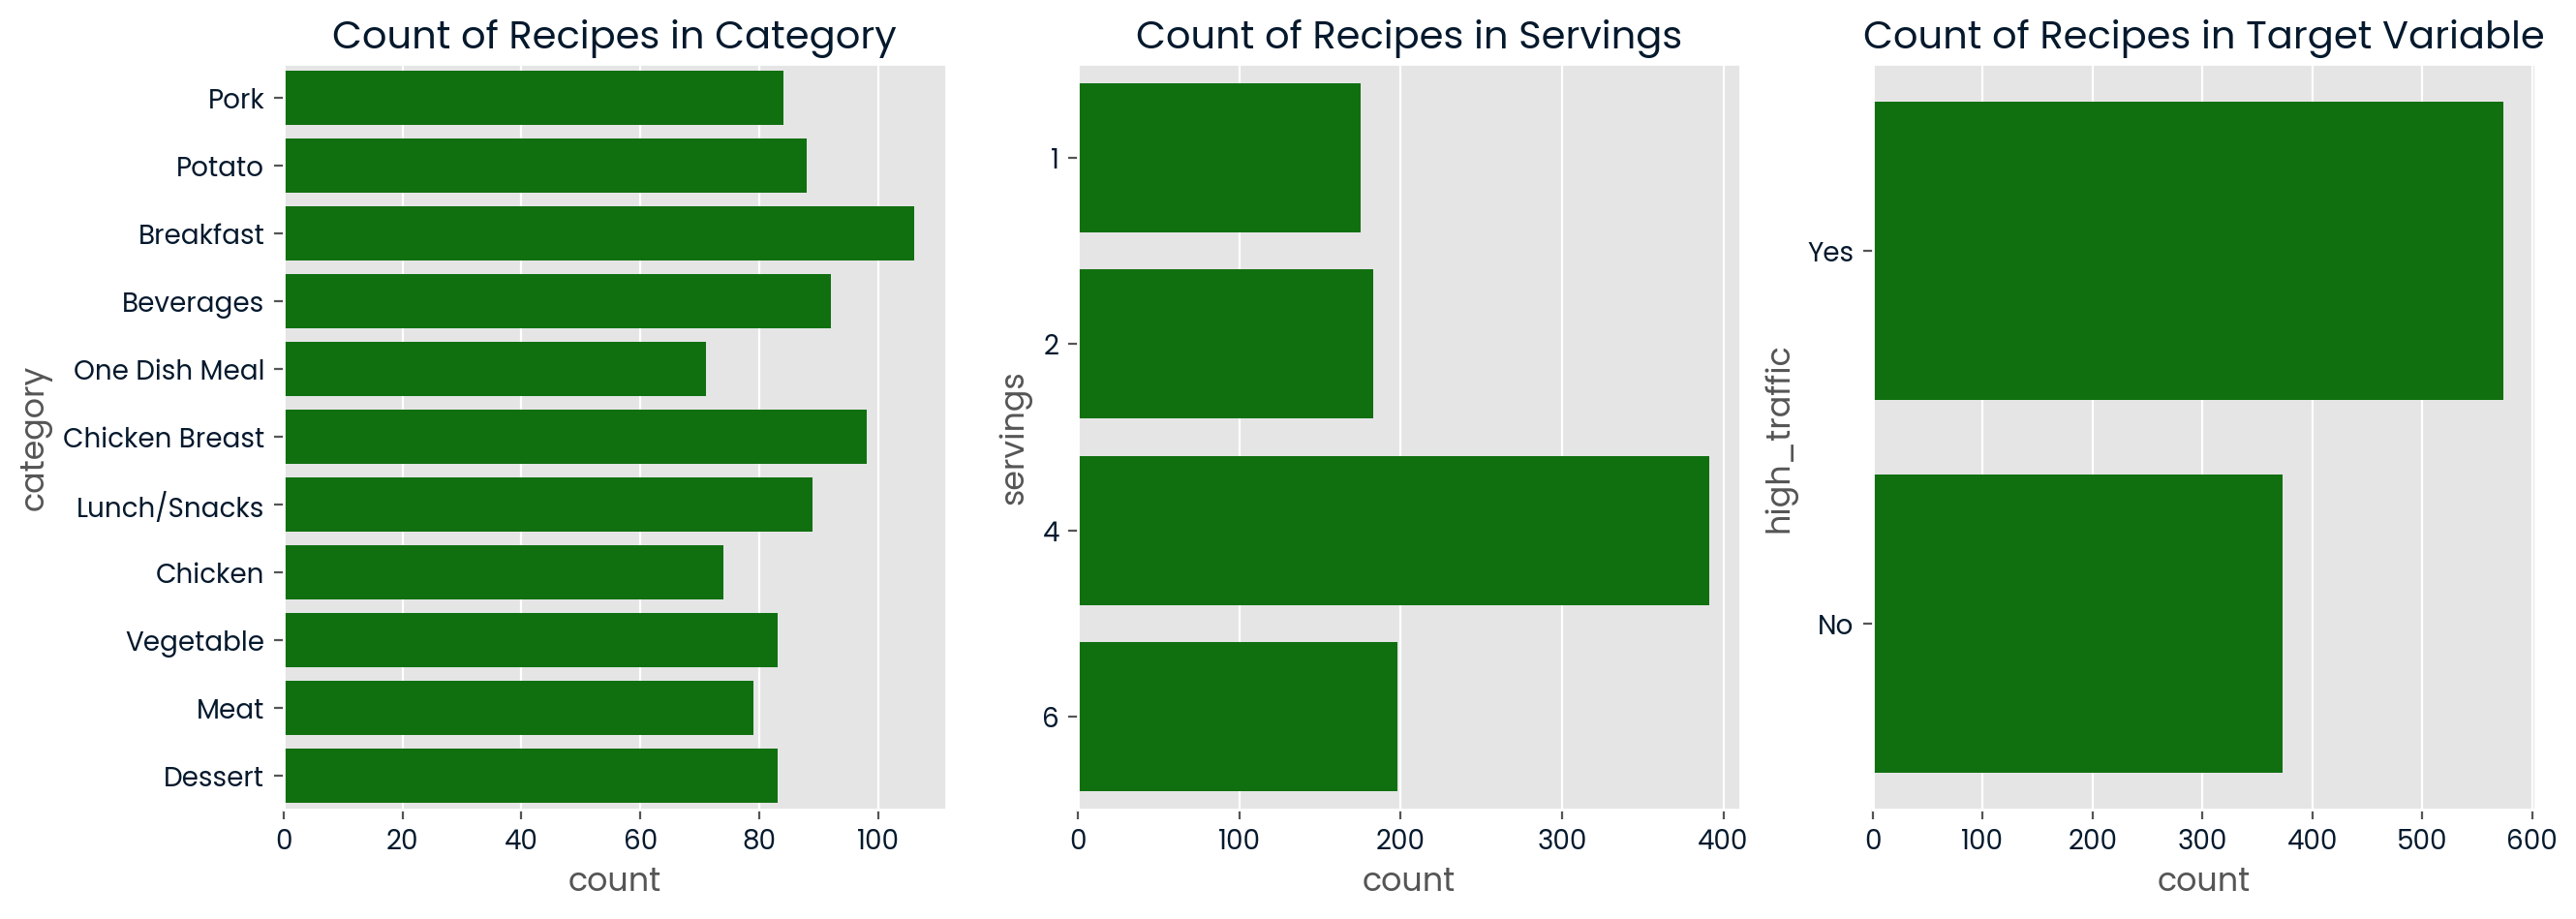

In [91]:
# Check the distribution of categorical variables
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
sns.countplot(data = rec, y = "category", ax = ax[0], color = "green").set_title("Count of Recipes in Category")
sns.countplot(data = rec, y = "servings", ax = ax[1], color = "green").set_title("Count of Recipes in Servings")
sns.countplot(data = rec, y = "high_traffic", ax = ax[2], color = "green").set_title("Count of Recipes in Target Variable")
plt.show()

- ## Features Relationship (Numerical Features)
I have investigated the relationship between numerical features and found that there was poor correlations between them suggesting that their relationships were not linear. For better understanding I used scatter plots and found out their relationships accross target variable were non-linear as well.

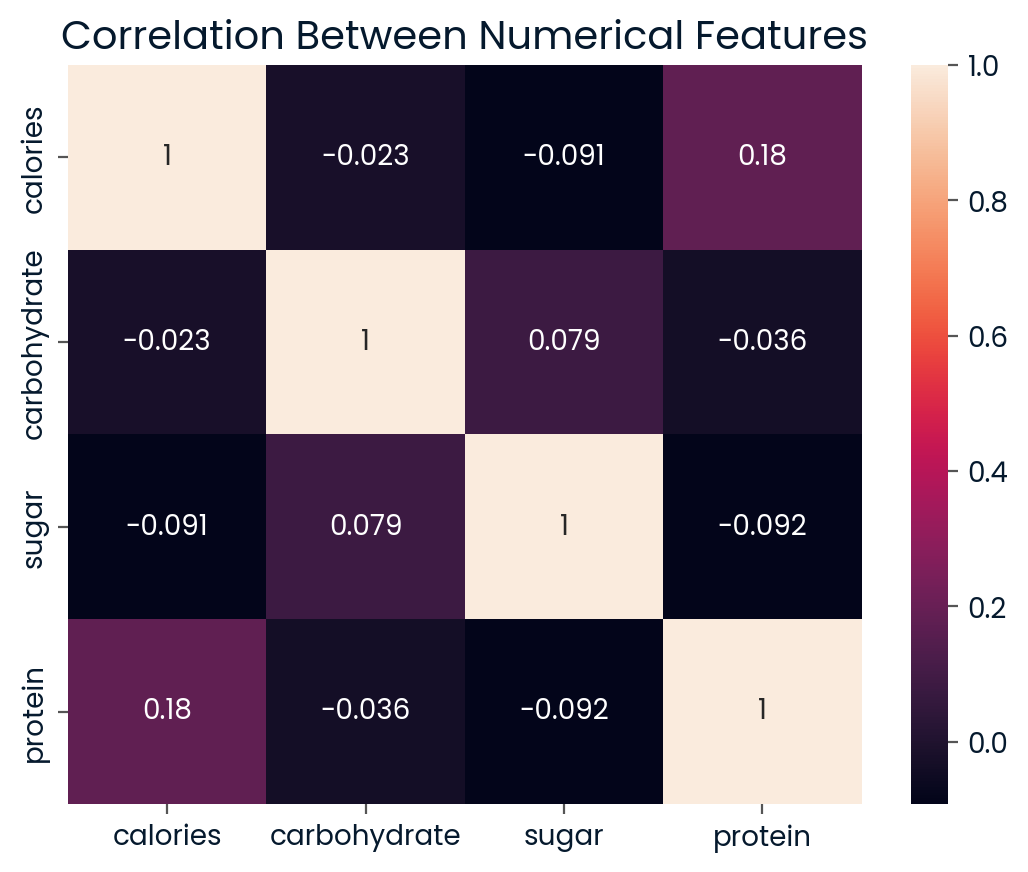

In [92]:
# Check the correlation between numerical features.
corr = rec[numeric].corr()
sns.heatmap(corr, annot = True)
plt.title("Correlation Between Numerical Features")
plt.show()

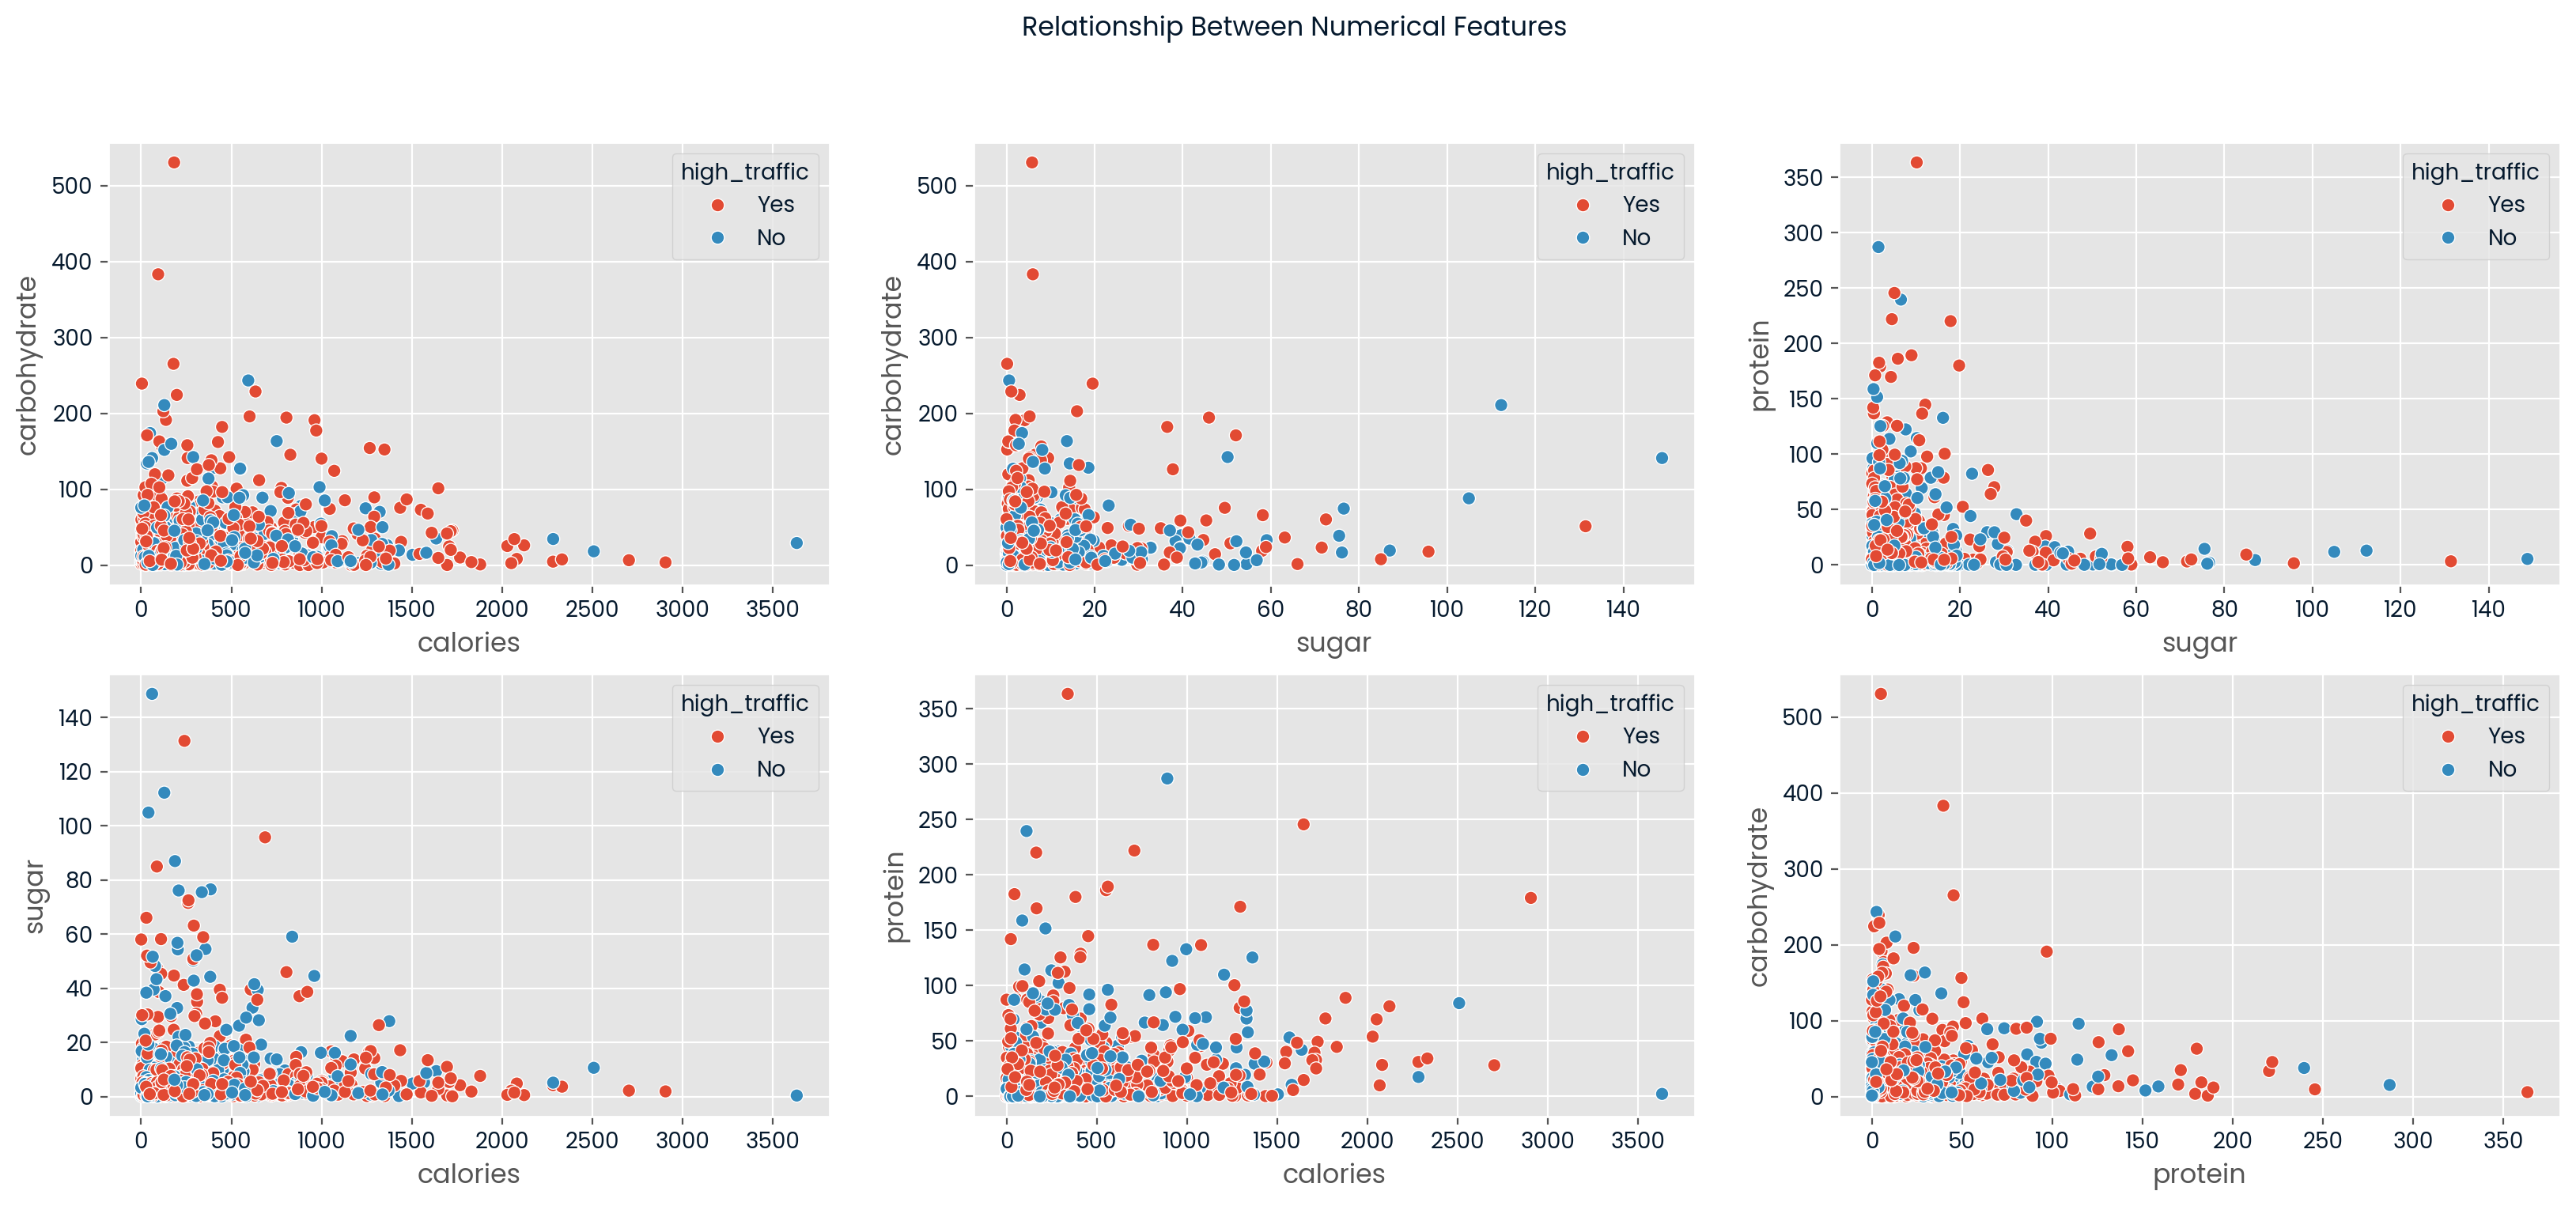

In [93]:
# Check the relationship between numeric features.
fig, ax = plt.subplots(2, 3, figsize = (20, 8))
sns.scatterplot(data = rec, x = "calories", y = "carbohydrate", ax = ax[0,0], hue = "high_traffic")
sns.scatterplot(data = rec, x = "sugar", y = "carbohydrate", ax = ax[0,1], hue = "high_traffic")
sns.scatterplot(data = rec, x = "sugar", y = "protein", ax = ax[0,2], hue = "high_traffic")
sns.scatterplot(data = rec, x = "calories", y = "sugar", ax = ax[1,0], hue = "high_traffic")
sns.scatterplot(data = rec, x = "calories", y = "protein", ax = ax[1,1], hue = "high_traffic")
sns.scatterplot(data = rec, x = "protein", y = "carbohydrate", ax = ax[1,2], hue = "high_traffic")
plt.suptitle("Relationship Between Numerical Features")
plt.show()

- ## Features Relationship (Categorical Features vs Target Variable)
I have investigated the category feature and found out the recipes with Potato was the most driver of high traffic on webpage, followed by the one with Vegetable and then Pork. I also found that, from servings feature most of the recipes that led to high traffic were served to 4 people.

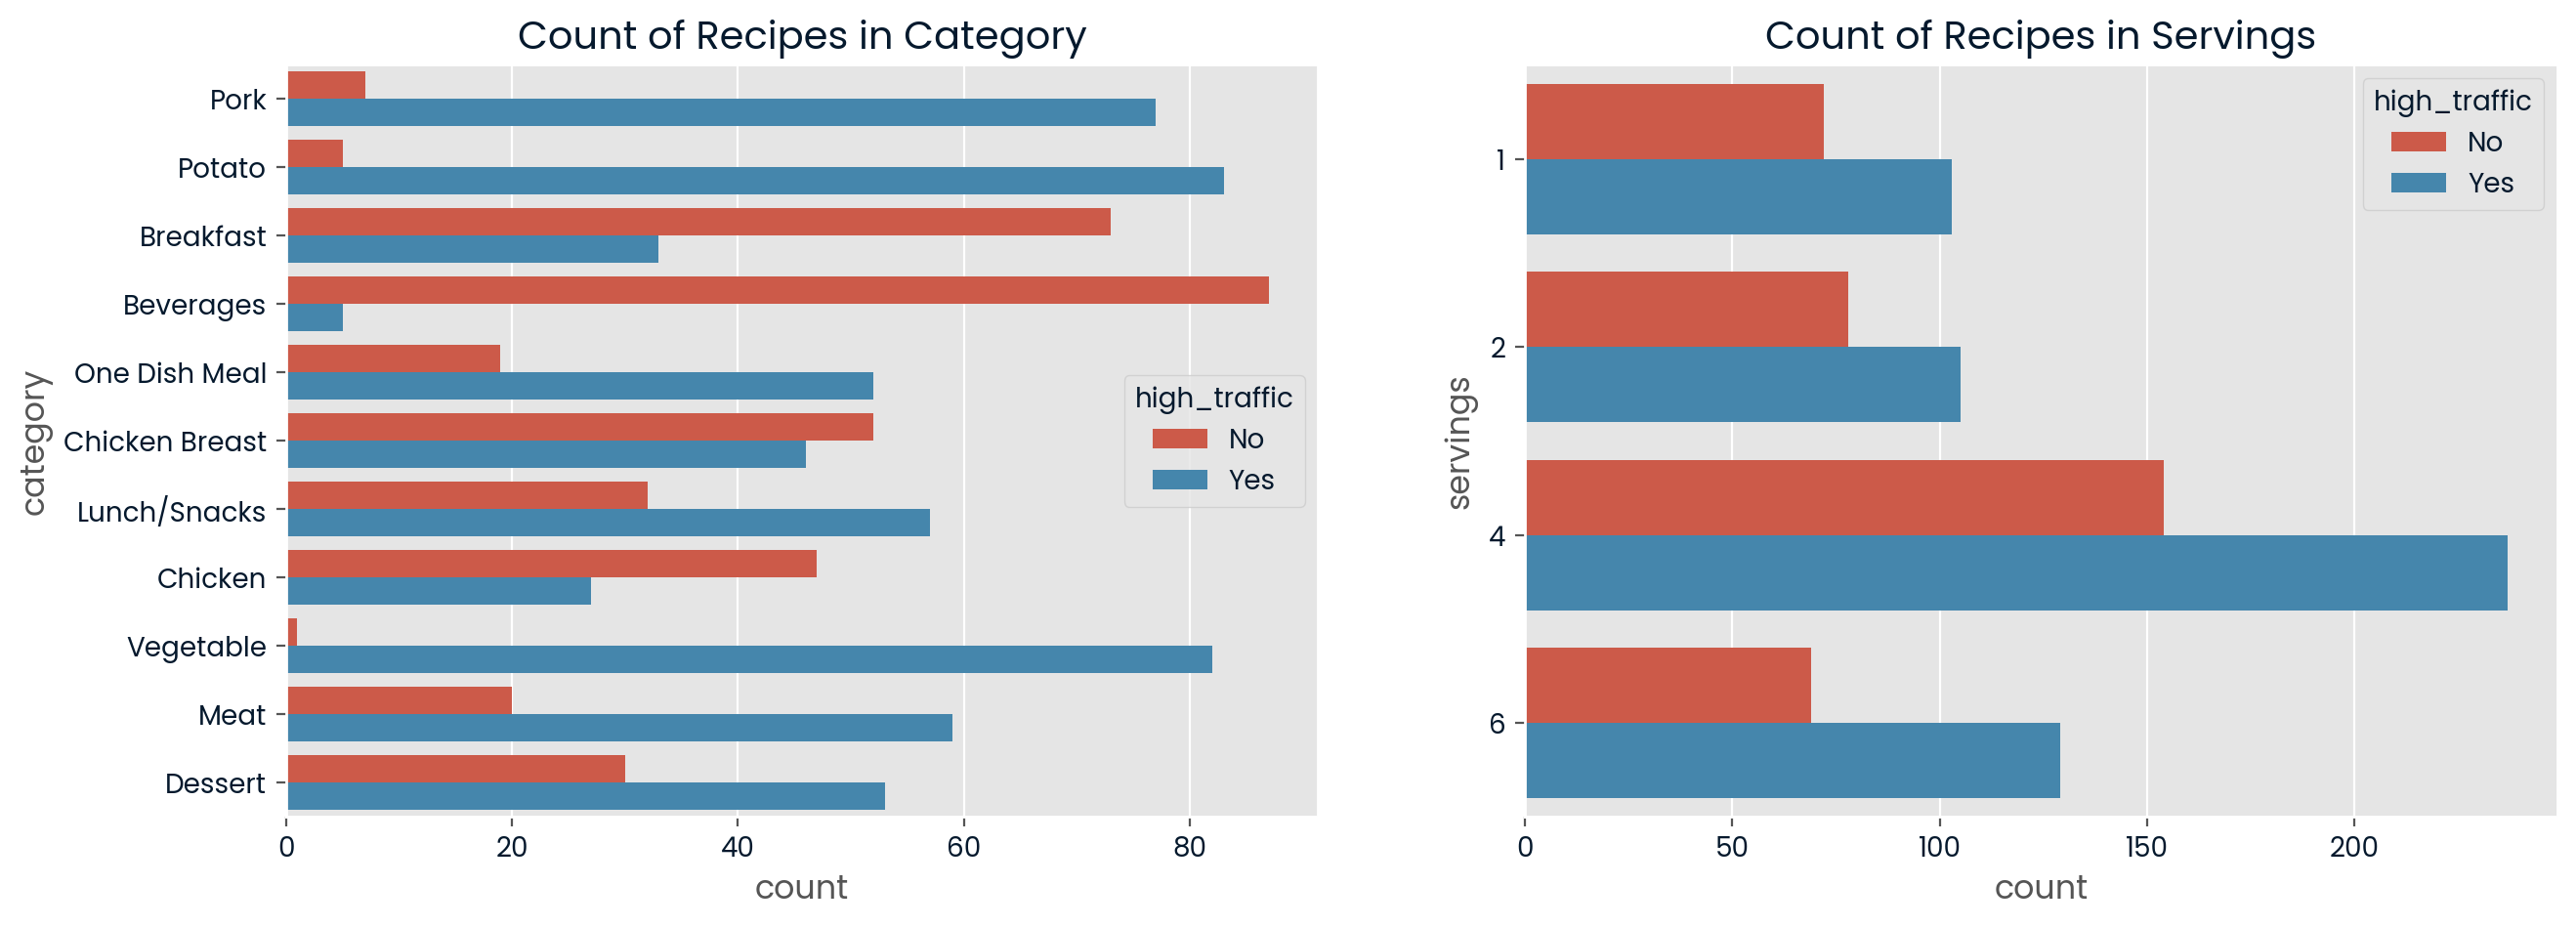

In [94]:
# Check the distribution of categorical features conditioned to target feature.
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
sns.countplot(data = rec, y = "category", ax = ax[0], hue = "high_traffic", hue_order = ["No", "Yes"]).set_title("Count of Recipes in Category")
sns.countplot(data = rec, y = "servings", ax = ax[1], hue = "high_traffic").set_title("Count of Recipes in Servings")
plt.show()

- ## Features Relationship (Numerical vs Categorical Features)
The boxplot below shows that the potato and pork categories of recipe with low number of calories drives high traffic on webpage while vegetable with high number of calories seem to drive high traffic. Moreover, I have found in the bar plots below, the Chicken Breast recipes with high amount of protein leads to high traffic as well as the Dessert with high amount of sugar.

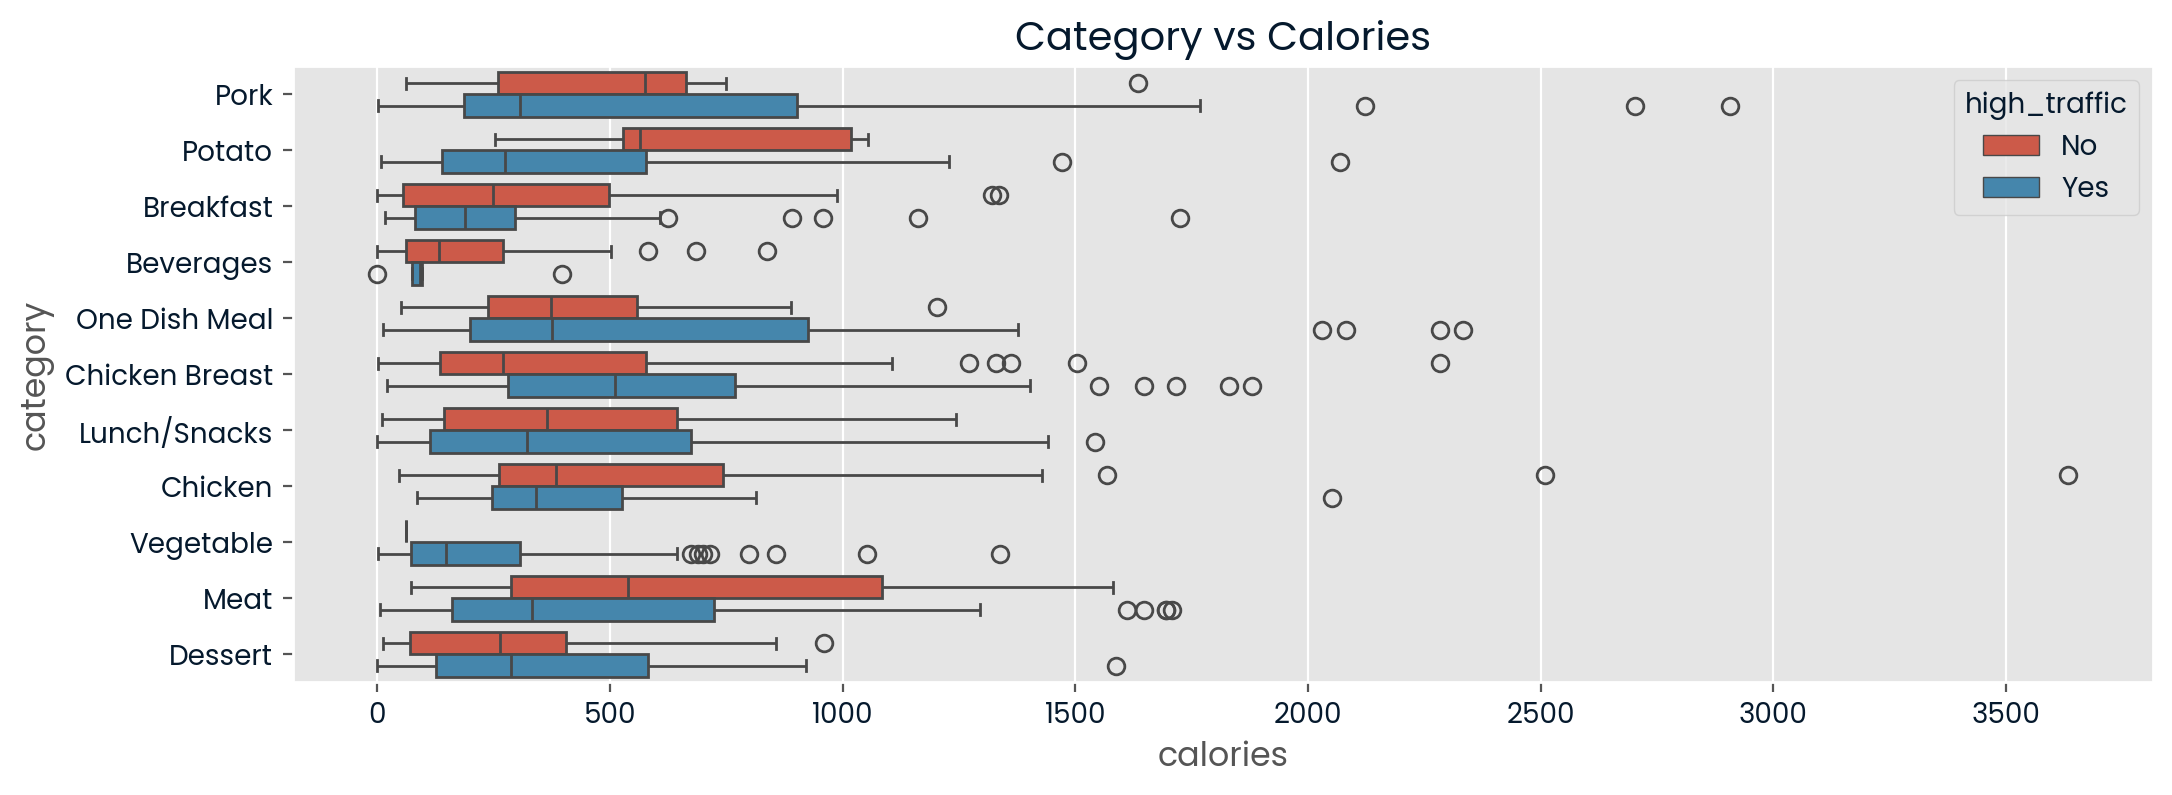

In [95]:
# Check the distribution of calories across category variable
fig, ax = plt.subplots(figsize = (12, 4))
sns.boxplot(data = rec, x = "calories", y = "category", ax = ax, hue = "high_traffic", hue_order = ["No", "Yes"]).set_title("Category vs Calories")
plt.show()

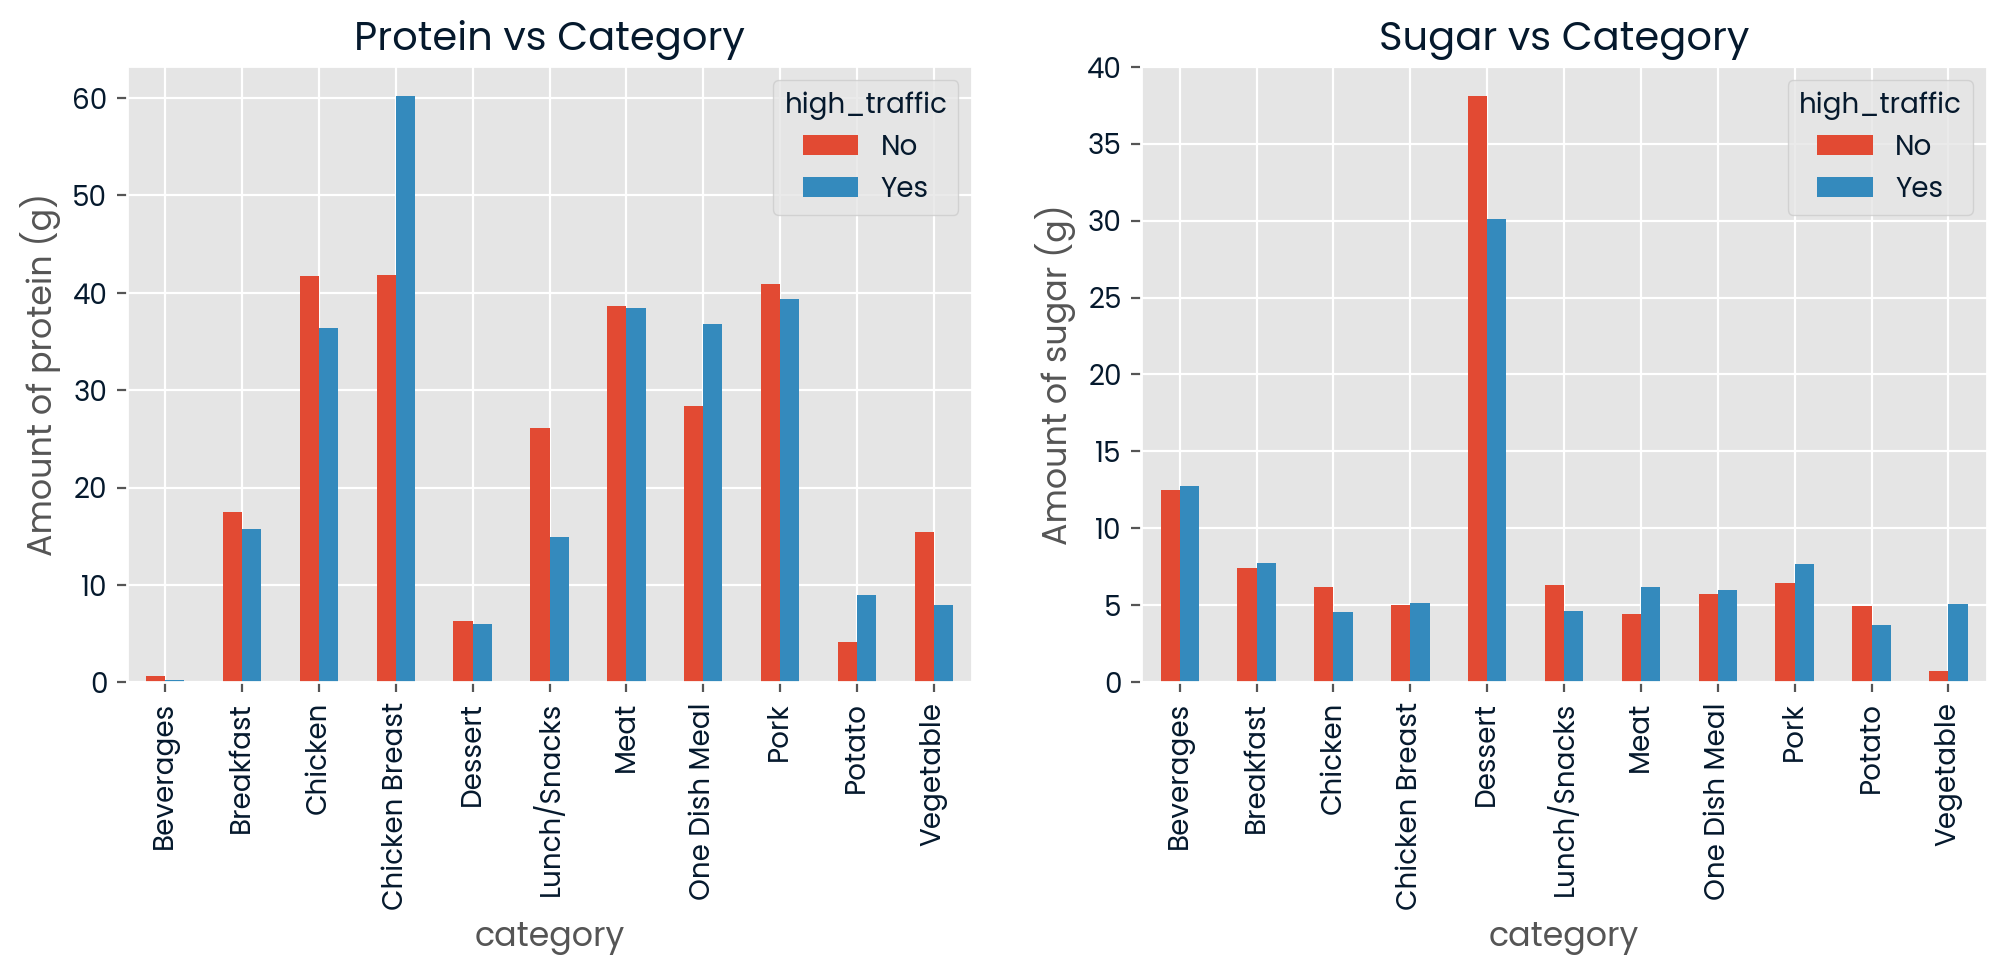

In [96]:
# Create pivot table for more analysis of protein and sugar.
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
table1 = rec.pivot_table(index = "category", columns = "high_traffic", values = "protein", aggfunc = "mean")
table2 = rec.pivot_table(index = "category", columns = "high_traffic", values = "sugar", aggfunc = "mean")
table1.plot(kind = "bar", ax = ax[0], ylabel = "Amount of protein (g)", title = "Protein vs Category")
table2.plot(kind = "bar", ax = ax[1], ylabel = "Amount of sugar (g)", title = "Sugar vs Category")
plt.show()

## Model Development
To predict which recipe will lead to high traffic is a classification problem in machine learning. I am choosing the  Logistic Regression because it is simple to interpret and suitable for binary classification, often perform well in small dataset with more numerical features like the one we have. The comparison model I am choosing is Random Forest because it can capture complex non-linear relationship, and it is less prone to outliers and overfitting. 

- ## Data Preparation For Modelling
To enable modelling, I used calories, protein, carbohydrate, sugar, servings, category as independent variables and high_traffic as our target variable. Moreover, I did the following preprocessings before modelling:
- Standardize the numerical features
- Converting categorical features into numerical features
- Splitting the dataset into train and test set.
- I also dropped recipe column because in my opinion it only identifies the recipes.

In [97]:
# Import libraries for ML modelling.
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve

In [98]:
# Drop the unique identifier column.
df = rec.drop("recipe", axis = 1)
# Categorical columns.
cat = ["category", "high_traffic"]
# Instantiate labelencoder
label_enc = LabelEncoder()
# Define function to encode categorical features.
def encoder(col):
    if col.name in cat:
        return label_enc.fit_transform(col)
    else:
        return col
# Apply the function.
df2 = df.apply(encoder)
# Check the new dataframe.
df2.head()    

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,288.55,21.48,4.55,10.80,8,6,1
1,35.48,38.56,0.66,0.92,9,4,1
2,914.28,42.68,3.09,2.88,1,1,0
3,97.03,30.56,38.63,0.02,0,4,1
4,27.05,1.85,0.80,0.53,0,4,0


In [99]:
# Get the target variable and independent variables.
y = df2["high_traffic"]
X = df2.drop("high_traffic", axis = 1)

In [100]:
# Split the data into train and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2024, stratify=y)
# Create the Scaler.
scaler = StandardScaler()
# Transform numeric features.
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
# Instantiate logistic regression.
lr = LogisticRegression(C = 0.01, penalty = "l1", solver = "liblinear")
# Fit the model.
lr.fit(X_train, y_train)
# Make prediction.
y_pred_lr = lr.predict(X_test)
# Make prediction of probabilities
y_score_lr = lr.predict_proba(X_test)[:, 1]
# Measure performance.
auc_lr = roc_auc_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
print("AUC for LogisticRegression: {:.2f}".format(auc_lr))
print("Precision for LogisticRegression: {:.2f}".format(precision_lr))

AUC for LogisticRegression: 0.68
Precision for LogisticRegression: 0.71


In [101]:
# Hyperparameter tuning for LogisticRegression.
# Define grid of parameters.
param_grid = {
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']
             }
# Define the GridSearchCV object.
searchcv = GridSearchCV(lr, param_grid = param_grid, cv = 5, scoring = "roc_auc", n_jobs = -1) 
# Fit the model.
searchcv.fit(X_train, y_train)
# Get the best parameters.
best_par_lr = searchcv.best_params_
print("Best parameters for LogisticRegression:" ,best_par_lr)

Best parameters for LogisticRegression: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [102]:
# Instantiate the RandomForest.
rf = RandomForestClassifier(random_state = 2024, n_estimators = 100, max_depth = 3, criterion = "entropy")
# Fit the model.
rf.fit(X_train, y_train)
# Make predictions.
y_pred_rf = rf.predict(X_test)
# Make predictions of probabilities.
y_score_rf = rf.predict_proba(X_test)[:, 1]
# Measure performance.
auc_rf = roc_auc_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
print("AUC for RandomForest: {:.2f}".format(auc_rf))
print("Precision for RandomForest: {:.2f}".format(precision_rf))

AUC for RandomForest: 0.73
Precision for RandomForest: 0.78


In [103]:
# Tuning the hyperparameters of RandomForest.
# Define grid of parameters.
params = {"n_estimators": np.arange(50, 250, 50),
         "max_depth": np.arange(2, 8),
         "criterion": ["gini", "entropy"]}
# Define the GridSearchCV object.
search = GridSearchCV(rf, param_grid = params, cv = 5, scoring = "roc_auc", n_jobs = -1) 
# Fit the model.
search.fit(X_train, y_train)
# Get the best parameters.
best_par_rf = search.best_params_
print("Best parameters for RandomForest:", best_par_rf) 

Best parameters for RandomForest: {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100}


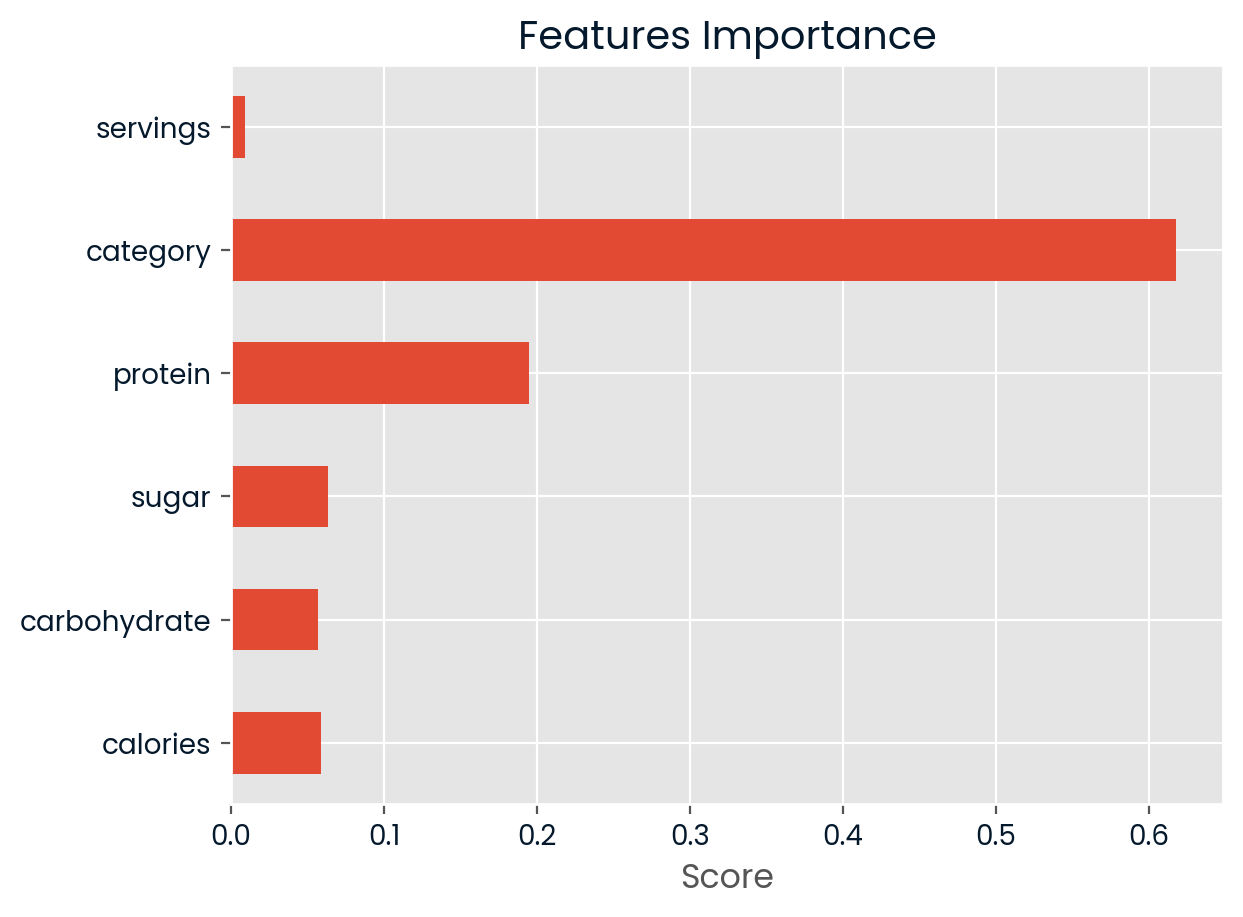

In [104]:
# Find the features importance.
feat_import = pd.Series(rf.feature_importances_, index = X_train.columns)
feat_import.plot(kind = "barh", title = "Features Importance", xlabel = "Score")
plt.show()

## Model Evaluation
To measure the performance of two models, I have chosen **AUC** (Area Under the ROC Curve). **AUC** score is the measure of separability. It tells how much the model is capable of distinguishing between classes at different probability thresholds. It is suitable metric when working with imbalanced classes like the one we have.
- ## Results
The AUC score of the LogisticRegression and RandomForest model is 0.68 and 0.73, indicating that **RandomForest**  model performs better than LogisticRegression in separating the two classes.

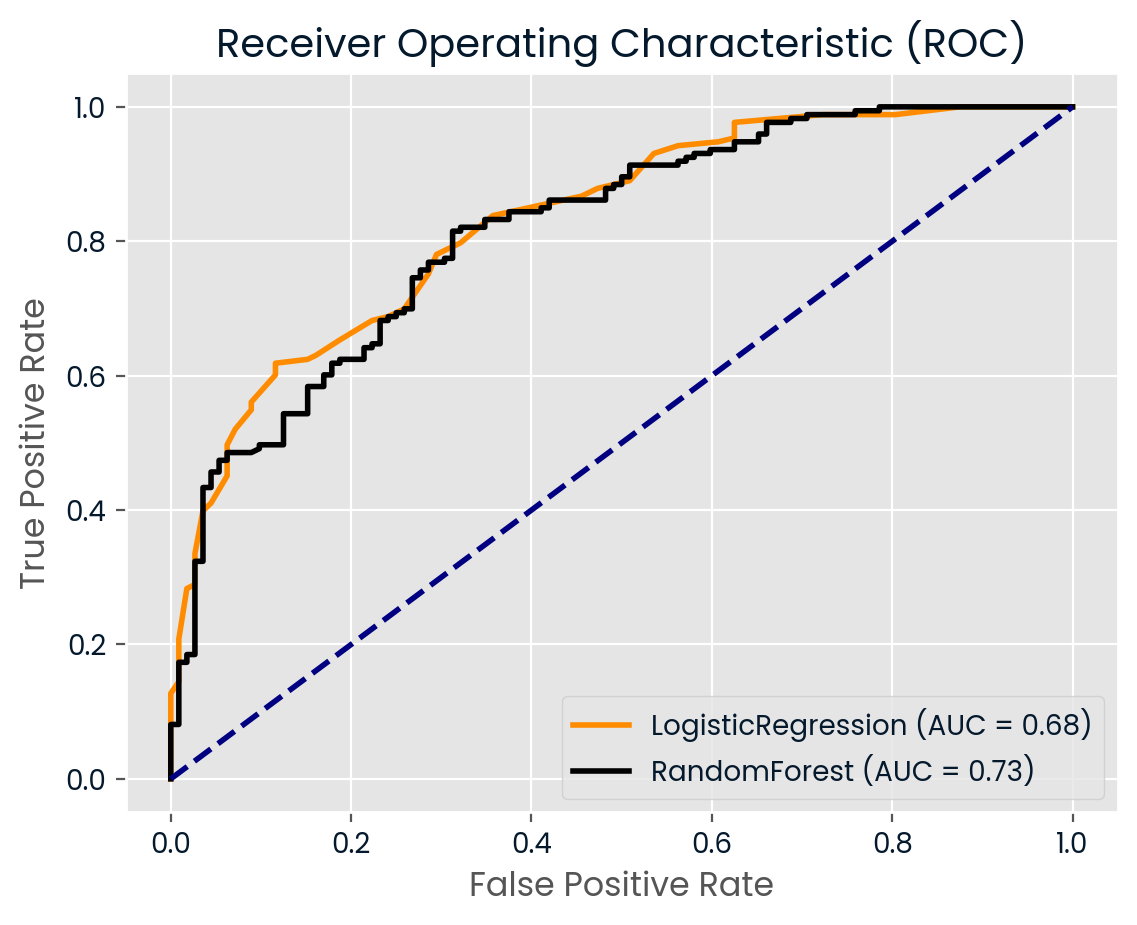

In [105]:
# Compute ROC curve for LogisticRegression.
fpr_lr, tpr_lr, threshold = roc_curve(y_test, y_score_lr)
# Compute ROC curve for RandomForest.
fpr_rf, tpr_rf, threshold = roc_curve(y_test, y_score_rf)
# Plot ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='LogisticRegression (AUC = %0.2f)' % auc_lr)
plt.plot(fpr_rf, tpr_rf, color = "k", lw = 2, label = 'RandomForest (AUC = %0.2f)' % auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Business Metrics
The company wants to predict which recipes will be popular 80% of the time and minimizing the chance of showing unpopular recipes. Therefore, we would consider using **precision** as KPI to compare our models again, the higher precision means the model performs better. Precision measures the proportion of true positive predictions among all positive predictions made by the classifier. It is calculated as, **precision = TP/(TP+FP)**. High precision means positive predictions (popular recipes) made by the model are mostly correct and the number of false positives (unpopular recipes) is low.
## Evaluation by Business Metrics
The precision of LogisticRegression and RandomForest is 0.71 and 0.78, suggesting that **RandomForest** performs better than LogisticRegression by correctly predicts the positive class (popular recipes) **78%** of the time. 

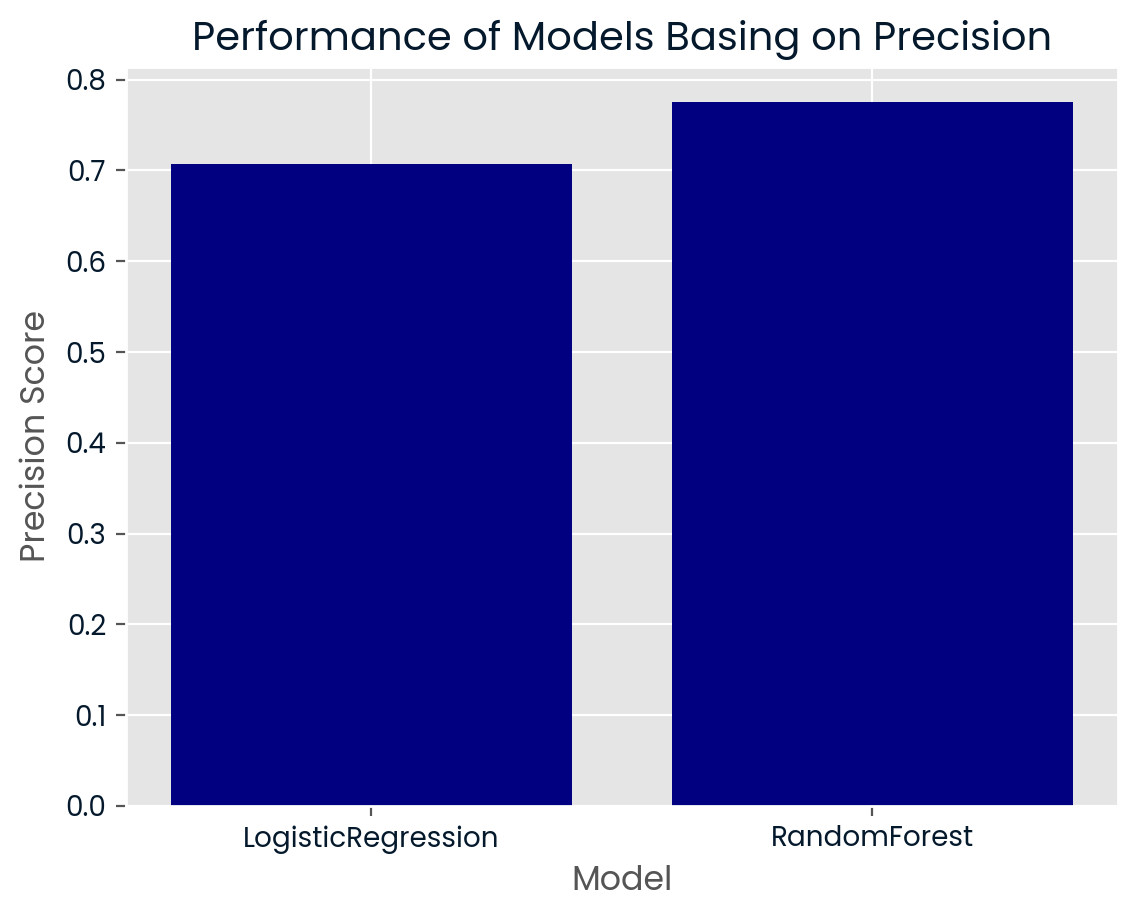

In [106]:
# Compare two models basing on precision scores.
precisions = dict(LogisticRegression = precision_lr, RandomForest = precision_rf)
plt.bar(precisions.keys(), precisions.values(), color = "navy")
plt.title("Performance of Models Basing on Precision")
plt.ylabel("Precision Score")
plt.xlabel("Model")
plt.show()

## Recommendations
Basing on business metric performance we have compared, we can plan to deploy the **RandomForest** into production. By implementing this model, we will be able to predict popular recipes **78%** of the time while minimizing the chance of unpopular recipes. This will simplify the process of displaying popular recipes on webpage which drives high traffic and hence more subscribers to the company products. I would like to recommend the followings to ensure the model is deployed and improved regularly: 
-  Choose an appropriate deployment method, such as deploying as a web service, containerizing the model, or integrating it into the existing software infrastructure.
-  Implement monitoring tools and processes to track the model performance over time. Set up alerts for any deviations from expected performance or changes in model behaviour that may require attention.
-  Regularly retrain the model on new data to keep it updated and maintain it's performance and relevance. Use techniques such as online learning or incremental training to update the model incrementally without requiring retraining from the scratch. 
-  Finally, for any replication of this work, you might consider including time variable in a dataset as well as trying feature engineering like protein to carbohydrate ratio and number of calories per serving.